# ✍ Ensemble Learning 이란?


- 여러 모델을 학습시켜 그 모델들의 예측 결과를 활용하는 방법


- 평행으로 학습하는 Bagging과 순차적으로 학습하는 Boosting으로 나눌 수 있음


- 각 모델이 어느 정도 이상의 성능을 내고, 동시에 다양성을 띄고 있을 때 가장 좋은 결과를 얻을 수 있음


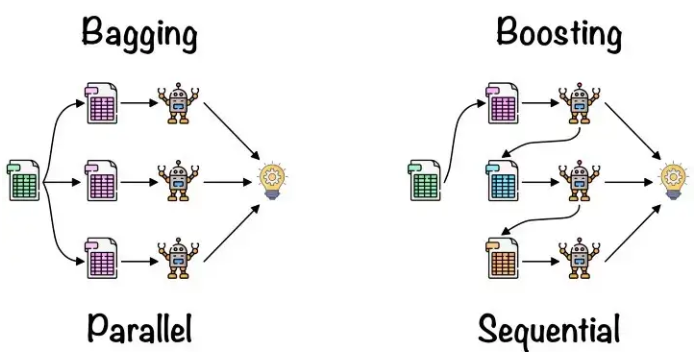



----------------------------

# 👆 What is Bagging?

- **Bagging의 핵심 아이디어**는 훈련 세트에서 무작위 샘플로 별도로 훈련된 여러 기본 학습자를 사용하는 것이며, 투표 또는 평균화 접근 방식을 통해 보다 안정적이고 정확한 모델을 생성하는 것이다. 


- 따라서 Bagging의 주요 두 가지 구성 요소는 교체를 사용한 **무작위 샘플링(Bootstraping)과 동종 머신러닝 학습 알고리즘 세트(Ensemble Learning)**이다. 


- **Bagging을 학습하는 과정**은 다음과 같다. 먼저 훈련 세트에서 "n"개의 하위 집합을 추출한 다음, 이 하위 집합들을 동일한 유형의 "n"개의 학습자를 훈련시키는 데 사용한다. 그리고 예측을 위해 "n"개의 학습자 각각에게 테스트 샘플을 제공하고, 각 학습자의 출력을 평균화(회귀)하거나 투표(분류)한다. 

In [1]:
# For this basic implementation, we only need these modules
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
# Load the well-known Breast Cancer dataset
# Split into train and test sets
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=23)

### ▶ DecisionTreeClassifier

### ✔ <u>DecisionTreeClassifier 하이퍼 파라미터</u>



1. `min_samples_split`

    - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
    
    - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가. 
    
     
    
2. `min_samples_leaf`

    - 말단 노드가 되기 위한 최소한의 샘플 수 
    
    - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
    
    
   
3. `max_features`

    - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature를 사용하여 분할. 
    
    - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature의 퍼센트
    
    - sqrt는 전체 feature 중 제곱근 값, auto는 sqrt와 동일, log는 전체 feature의 log2() 값
    
       
    
4. `max_depth`

    - 트리의 최대 깊이 지정
    
    - default는 None으로 이는 완벽히 클래스 결정값이 될 때까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 `min_samples_split`보다 작아질 때까지 계속 분할
    
    - 깊이가 깊어지면 `min_samples_split` 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어

#### 1. DecisionTreeClassifier

In [3]:
'''DT hyperparameter'''
DT_config = ParameterGrid({
    'min_samples_split':[2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ["sqrt", "log2"]})


'''Train & Prediction'''
scores = []
min_samples_leaf = []
min_samples_split = []
max_features = []

for param in DT_config:
    model = DecisionTreeClassifier(**param).fit(x_train, y_train)
    pred_Y = model.predict(x_test)
    score = accuracy_score(y_test, pred_Y)
    
    scores.append(score)
    min_samples_leaf.append(param['min_samples_leaf'])
    min_samples_split.append(param['min_samples_split'])
    max_features.append(param['max_features'])


'''Result'''
df_DT = pd.DataFrame({'accuracy':scores,
              'min_samples_leaf':min_samples_leaf,
             'min_samples_split':min_samples_split,
             'max_features': max_features})    

In [4]:
df_DT[df_DT['accuracy'] == df_DT['accuracy'].max()] # 가장 성능 좋을 때의 파라미터

,accuracy,min_samples_leaf,min_samples_split,max_features
31,0.972028,4,5,log2


### ▶ BaggingClassifier


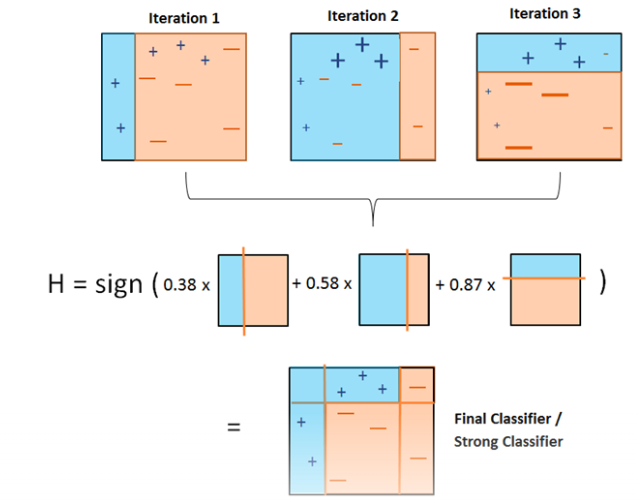

### ✔ <u>Bagging 하이퍼 파라미터</u>



1. `n_estimators`

    - 모델의 갯수로 데이터셋을 몇 개 만들지
    
    - defult는 10
     
    
2. `max_samples`

    - 하나의 예측기에 들어가는 샘플들이 랜덤하게 들어감
    
    - 랜덤하게 전체 데이터의 몇 %씩 들어갈지 정하는 것
    
    - 줄일수록 서로 다른 것들을 배운 예측기들이 모일 수 있는 가능성이 높아짐.
    
    
   
3. `bootstrap`

    - 데이터를 중복해서 사용할건지 말건지
    
    - default는 True
    
    - 중복하는 것은 데이터를 좀 더 깊게 배우라는 의미
    

#### 2. 가장 성능 좋게 나온 파라미터로 구성된 DecisionTreeClassifier로 base_estimator 고정하고, BaggingClassifier 학습

In [5]:
'''DT with the best performance parameters '''
tree = DecisionTreeClassifier(min_samples_leaf=3,min_samples_split=2,max_features='sqrt', random_state=23)


'''bagging hyperparameter'''
bagging_config = ParameterGrid({
    'n_estimators':[5, 10, 20, 40],
    'max_samples': [25, 50, 100, 200],
    'bootstrap': [True, False]})


'''Train & Prediction'''
scores = []
n_estimators = []
max_samples = []
bootstrap = []

for param in bagging_config:
    model = BaggingClassifier(base_estimator=tree, **param).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    
    scores.append(score)
    n_estimators.append(param['n_estimators'])
    max_samples.append(param['max_samples'])
    bootstrap.append(param['bootstrap'])

    
'''Result'''
df_bagging = pd.DataFrame({'scores':scores,
              'n_estimators':n_estimators,
             'max_samples':max_samples,
             'bootstrap': bootstrap})    

In [6]:
df_bagging[df_bagging['scores'] == df_bagging['scores'].max()] # 가장 성능 좋을 때의 파라미터

,scores,n_estimators,max_samples,bootstrap
11,0.979021,40,100,True


#### 3. 다양한 DecisionTreeClassifier로 BaggingClassifier 학습

In [7]:
'''Train & Prediction'''
scores = []
min_samples_leaf = []
min_samples_split = []
max_features = []
n_estimators = []
max_samples = []
bootstrap = []


for param_1 in DT_config: 
    for param_2 in bagging_config:
        tree = DecisionTreeClassifier(**param_1, random_state=23)
        model = BaggingClassifier(base_estimator=tree, **param_2).fit(x_train, y_train)
        score = model.score(x_test, y_test)

        scores.append(score)
        min_samples_leaf.append(param_1['min_samples_leaf'])
        min_samples_split.append(param_1['min_samples_split'])
        max_features.append(param_1['max_features'])
        n_estimators.append(param_2['n_estimators'])
        max_samples.append(param_2['max_samples'])
        bootstrap.append(param_2['bootstrap'])

        
'''Result'''
df_DT_bagging = pd.DataFrame({'scores':scores,
                              'min_samples_leaf': min_samples_leaf, 
                              'min_samples_split': min_samples_split, 
                              'max_features': max_features, 
                              'n_estimators':n_estimators,
                             'max_samples':max_samples,
                             'bootstrap': bootstrap})    

In [8]:
df_DT_bagging[df_DT_bagging['scores'] == df_DT_bagging['scores'].max()] # 가장 성능 좋을 때의 파라미터

,scores,min_samples_leaf,min_samples_split,max_features,n_estimators,max_samples,bootstrap
860,0.993007,3,4,log2,5,200,False


## 🙌 <u>결과</u>

- 가장 성능 좋은 파라미터로 구성된 DT로 bagging을 실험한 결과, DT보다 성능이 좋지 않았다. 


- 하지만, 여러 DT로 bagging을 실험한 결과 기존 가장 성능이 좋았던 DT보다 성능이 좋아졌다.
    **(0.972028 → 0.986014)**
    
    
- bagging에서도 하이퍼 파라미터를 조절하므로, DT에서 가장 좋은 성능을 보이는 파라미터에서 반드시 가장 좋은 성능을 보이는 건 아닌 것 같다. 


- 또한 bagging에서는 가장 좋은 성능을 보이는 파라미터의 조합들이 여러가지인 점으로 보아, 비교적 하이퍼 파라미터에 로버스트한 성질을 띄는 것 같다. 


------------------------------

#  👆 What is Boosting?

- Boosting은 Bagging과 마찬가지로 ML 모델의 안정성과 효과를 향상시키기 위해 기본 학습자 세트를 사용하는 앙상블 학습 기술임


- Boosting의 아이디어는 모델의 순차적 학습이며, 각 모델은 이전 모델에서 발생한 실수를 개선하거나 수정하려고 함


- 대표적인 모델로는 AdaBoost(Adaptive Boost), XGBoost(Extreme Gradient Boost), LightGBM(Light Gradient Boost)가 있음

### ▶ AdaBoost

- 가중치 벡터를 구현함으로써 잘못 추론된 샘플에 불이익을 주고(weight를 줄임) 올바르게 추론된 샘플에 보상한다. 


- 따라서 이 가중치 벡터를 업데이트하면, 더 높은 가중치로 잘못 추론된 샘플을 고려할 가능성이 높은 분포가 생성된다. 


- AdaBoost는 위와 같이 순차적으로 학습시켜 개별 학습기에 가중치를 부여하여 모두 결합한다. 


- 예를 들어 첫 번째 학습기에는 가중치 0.3, 두 번째 학습기에는 가중치 0.5, 세 번째 학습기에는 가중치 0.8을 부여하여 모두 결합하여 예측을 수행한다. 

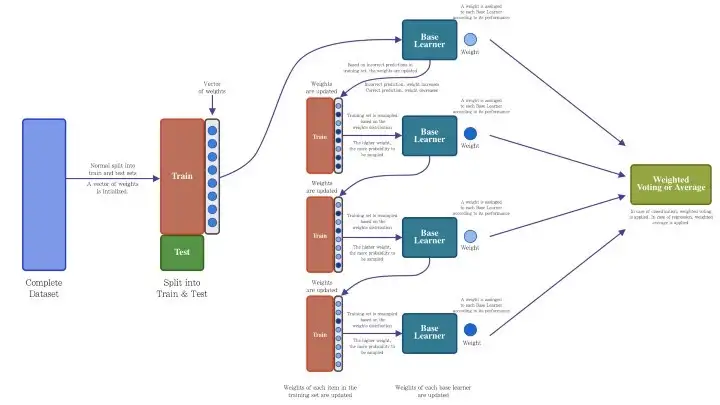

### ✔ <u>AdaBoost 하이퍼 파라미터</u>



1. `n_estimators`

    - 생성할 약한 학습기의 개수를 지정
    
    - default는 50임. 
    
    - 높게 설정하면 여러 학습기들의 decision boundary가 많아지면서 모델이 복잡해질 수 있음
     
    
2. `learning_rate`

    - 학습을 진행할 때마다 적용하는 학습률
    
    - 약한 학습기가 순차적으로 오류 값을 보정해 나갈 때 적용하는 계수
    
    - default는 1임
    
    - 낮게 설정하면 가중치의 갱신 변동폭이 감소해서 여러 학습기들의 decision boundary의 차이가 줄어듦

In [9]:
from sklearn.ensemble import AdaBoostClassifier

'''AdaBoost hyperparameter'''
AdaBoost_config = ParameterGrid({
    'n_estimators':[25, 50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1, 1]})


'''Train & Prediction'''
scores = []
min_samples_leaf = []
min_samples_split = []
max_features = []
n_estimators = []
learning_rate = []


for param_1 in DT_config: 
    for param_2 in AdaBoost_config:
        tree = DecisionTreeClassifier(**param_1, random_state=23)
        model = AdaBoostClassifier(base_estimator=tree, **param_2).fit(x_train, y_train)
        score = model.score(x_test, y_test)

        scores.append(score)
        min_samples_leaf.append(param_1['min_samples_leaf'])
        min_samples_split.append(param_1['min_samples_split'])
        max_features.append(param_1['max_features'])
        n_estimators.append(param_2['n_estimators'])
        learning_rate.append(param_2['learning_rate'])
        
'''Result'''
df_DT_AdaBoost = pd.DataFrame({'scores':scores,
                              'min_samples_leaf': min_samples_leaf, 
                              'min_samples_split': min_samples_split, 
                              'max_features': max_features, 
                              'n_estimators':n_estimators,
                             'learning_rate':learning_rate})  

In [10]:
df_DT_AdaBoost[df_DT_AdaBoost['scores'] == df_DT_AdaBoost['scores'].max()] # 가장 성능 좋을 때의 파라미터

,scores,min_samples_leaf,min_samples_split,max_features,n_estimators,learning_rate
61,0.993007,1,5,sqrt,50,1.00
87,0.993007,2,3,sqrt,150,0.01
102,0.993007,2,4,sqrt,100,0.01
110,0.993007,2,4,sqrt,100,1.00
126,0.993007,2,5,sqrt,100,1.00
156,0.993007,3,3,sqrt,25,1.00
173,0.993007,3,4,sqrt,50,1.00
181,0.993007,3,5,sqrt,50,0.01
222,0.993007,4,3,sqrt,100,1.00
245,0.993007,4,5,sqrt,50,0.01


## 🙌 <u>결과</u>

- Bagging 방법보다 Boosting 방법이 가중치를 업데이트하는 방식으로 학습되어서 그런지 성능이 좋다.

### ▶ Gradient Boosting


- Gradient Boosting은 가중치 벡터를 구현하지 않고, 주어진 손실 함수의 최적화를 위한 기울기 계산 (경사 하강법)을 구현한다.



- Gradient Boosting의 아이디어는 순차적인 방식으로 각 학습자 기반의 잔차를 최소화하는 것을 기반으로 하며, 이러한 최소화는 특정 손실 함수에 적용되는 gradient의 계산을 통해 수행된다. 



- 이전 기본 학습자에 의해 결정된 잔차를 최소하하면서 오류가 0에 가까울 때까지 이 과정을 반복한다. 


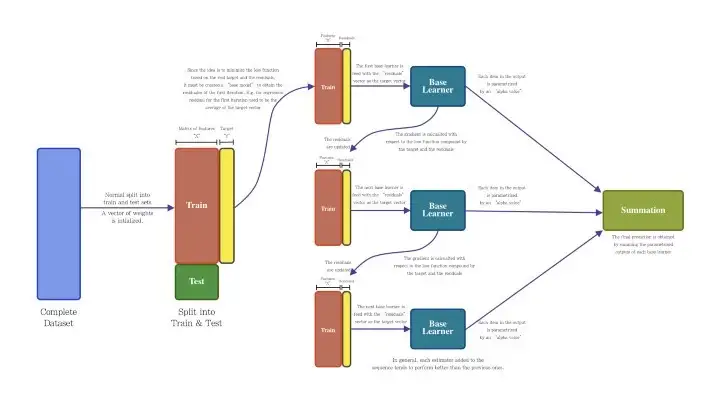

### ✔ <u> Gradient Boosting 하이퍼 파라미터 </u>



1. `n_estimators`

    - 생성할 트리의 갯수 지정
    
    - default는 100임. 
    
    - 많을 수록 성능이 좋아질 수는 있지만 시간이 오래 걸림
     
    
2. `learning_rate`

    - 학습을 진행할 때마다 적용하는 학습률
    
    - 약한 학습기가 순차적으로 오류 값을 보정해 나갈 때 적용하는 계수
    
    - default는 0.1임
        
    
3. `max_depth`

    - 트리의 최대 깊이
    
    - default는 3임.
    
    - 깊이가 깊어지면 과적합 될 수 있음.
    
    

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import time

start_time = time.time()

GBM_config = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001,0.01, 0.1, 1],
    'max_depth': [2,3,4,5]
}

gbm_clf = GradientBoostingClassifier(random_state = 23)

grid_cv = GridSearchCV(gbm_clf, param_grid = GBM_config, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('GBM 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 64 candidates, totalling 128 fits
최적 하이퍼 파라미터: 
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
최고 예측 정확도: 0.9577
GBM 수행시간: 29.0초


In [12]:
# GridSearchCV를 이용해 최적으로 학습된 estimators로 예측 수행
gbm_pred = grid_cv.best_estimator_.predict(x_test)
gb_accuracy = accuracy_score(y_test, gbm_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9720


## 🙌 <u>결과</u>

- 최적 하이퍼 파라미터에서 `n_estimator`가 가장 큰 값이 선택된 것으로 보아, `n_estimator`가 많을 수록 성능이 좋아지는 것이 입증되었다. 


- 또한 `max_depth`가 낮은 값으로 선택되었는데, 이는 과적합 될 위험이 적은 모델이고 결과적으로 test data에서의 GBM의 성능이 좋게 나왔다. 

### ▶ XGBoost


- Boosting 기법을 사용하여 구현한 알고리즘인 Gradient Boost를 병렬 학습이 지원되도록 구현한 알고리즘


- 성능과 자원 효율이 좋다는 장점을 가지고 있음


- 또한 과적합 규제 기능이 발달하여 강한 내구성을 가짐


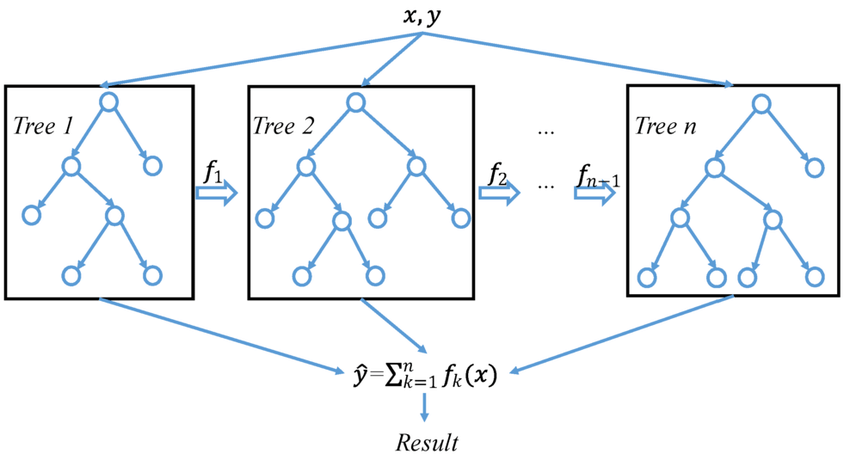

### ✔ <u> XGBoost 하이퍼 파라미터 </u>



1. `max_depth`

    - 트리의 maximum depth
    
    - default는 6임
    
    - `max_depth`가 높을 수록 모델의 복잡도가 커져 과적합 되기 쉬움
     
    
2. `min_child_weight`

    - 관측치에 대한 가중치 합의 최소
    
    - default는 1임
    
    - `min_child_weight`가 높을 수록 과적합 방지됨
        
    
3. `gamma`

    - 리프노드의 추가 분할을 결정할 최소 손실 감소값
    
    - 해당 값보다 손실이 크게 감소할 때 분리함. 
    
    - default는 0임
    
    - `gamma`가 높을 수록 과적합 방지됨.
    
    
4. `subsample`
    
    - weak learner가 학습에 사용하는 데이터 샘플링 비율
    
    - default는 1임
    
    - `subsample`가 낮을수록 과적합 방지됨. 
   

5. `colsample_bytree`
    
    - 각 tree별 사용된 feature의 퍼센테이지
    
    - default는 1임
    
    - `colsample_bytree`가 낮을수록 과적합 방지됨. 
   
   
6. `reg_alpha`
    
    - 가중치에 대한 L1 Regularization 적용 값
    
    - 피쳐 개수가 많을 때 적용하면 좋음. 
    
    - `reg_alpha`가 클수록 과적합 방지됨.     
    

#### 1. `max_depth`와 `min_child_weight`을 튜닝한다

In [13]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

start_time = time.time()

param_test1 = {
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5]}

XGB_clf = XGBClassifier(random_state = 23)

grid_cv = GridSearchCV(XGB_clf, param_grid = param_test1, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('XGBoost 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
최적 하이퍼 파라미터: 
 {'max_depth': 6, 'min_child_weight': 1}
최고 예측 정확도: 0.9624
XGBoost 수행시간: 0.8초


#### 2. `Gamma`를 튜닝한다

In [14]:
start_time = time.time()

param_test2 = {
    'gamma': [i/10.0 for i in range(0,5)]}

XGB_clf = XGBClassifier(random_state = 23, max_depth=6, min_child_weight=1) # 위에서 구한 최적 파라미터 고정

grid_cv = GridSearchCV(XGB_clf, param_grid = param_test2, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('XGBoost 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
최적 하이퍼 파라미터: 
 {'gamma': 0.0}
최고 예측 정확도: 0.9624
XGBoost 수행시간: 0.5초


#### 3. `subsample`과  `colsample_bytree`를 튜닝한다

In [15]:
start_time = time.time()

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

XGB_clf = XGBClassifier(random_state = 23, max_depth=6, min_child_weight=1, gamma=0) # 위에서 구한 최적 파라미터 고정

grid_cv = GridSearchCV(XGB_clf, param_grid = param_test3, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('XGBoost 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
최적 하이퍼 파라미터: 
 {'colsample_bytree': 0.6, 'subsample': 0.9}
최고 예측 정확도: 0.9718
XGBoost 수행시간: 1.5초


#### 4. `subsample` 추가 튜닝한다

In [16]:
start_time = time.time()

param_test4 = {
 'subsample':[i/100.0 for i in range(40,80)],
}

XGB_clf = XGBClassifier(random_state = 23, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.6) # 위에서 구한 최적 파라미터 고정

grid_cv = GridSearchCV(XGB_clf, param_grid = param_test4, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('XGBoost 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 40 candidates, totalling 80 fits
최적 하이퍼 파라미터: 
 {'subsample': 0.48}
최고 예측 정확도: 0.9765
XGBoost 수행시간: 3.6초


#### 5. Regularization Parameter `reg_alpha`을 튜닝한다

In [17]:
start_time = time.time()

param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

XGB_clf = XGBClassifier(random_state = 23, max_depth=6, min_child_weight=1, 
                        gamma=0, colsample_bytree=0.6, subsample=0.48) # 위에서 구한 최적 파라미터 고정

grid_cv = GridSearchCV(XGB_clf, param_grid = param_test5, cv=2, verbose=1, n_jobs=1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('XGBoost 수행시간: {:.1f}초'.format(time.time() - start_time))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
최적 하이퍼 파라미터: 
 {'reg_alpha': 1e-05}
최고 예측 정확도: 0.9765
XGBoost 수행시간: 0.6초


In [18]:
# GridSearchCV를 이용해 최적으로 학습된 estimators로 예측 수행
xgboost_pred = grid_cv.best_estimator_.predict(x_test)
xgb_accuracy = accuracy_score(y_test, xgboost_pred)
print('XGBoost 정확도: {0:.4f}'.format(xgb_accuracy))

XGBoost 정확도: 0.9790


## 🙌 <u>결과</u>


- 전체적인 트리 구조를 형성하는 것부터 하이퍼 파라미터 튜닝을 진행했다. 


- 파라미터를 튜닝할 수록 성능이 향상되는 것을 확인할 수 있었다. **(0.9624 → 0.9765)**


- 또한 과적합을 방지할 수 있다는 장점을 가진 모델이라 그런지, test data에서의 성능이 더 높게 나왔다. 


- 마지막으로, XGBoost의 가장 큰 특징인 병렬 학습을 지원해 학습 속도가 빠르다는 것을 수행시간을 통해 확인할 수 있었다. 
    
    **(GBM 수행시간: 28.9초 → XGBoost 수행시간: 0.5초)**

#### Reference

https://towardsdatascience.com/ensemble-learning-bagging-boosting-3098079e5422 (Ensemble 이미지)

https://subscription.packtpub.com/book/big-data-&-business-intelligence/9781788295758/4/ch04lvl1sec32/adaboost-classifier (AdaBoost 이미지)

https://gils-lab.tistory.com/10

https://sevillabk.github.io/Boosting/

https://wooono.tistory.com/97

https://jaaamj.tistory.com/40

https://www.kaggle.com/code/lifesailor/xgboost

https://www.researchgate.net/figure/A-general-architecture-of-XGBoost_fig3_335483097 (xgboost 이미지)

https://ybeaning.tistory.com/17

https://medium.com/analytics-vidhya/introduction-to-the-gradient-boosting-algorithm-c25c653f826b (boosting 이미지)